<a href="https://colab.research.google.com/github/tylergusmyers/ML_token_prices/blob/main/SOL_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model for predicting SOL-USD prices.

In [3]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
#Data Source
!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 6.4 MB 58.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Step 1: Import the SOL-USD OHLCV dataset into a Pandas DataFrame.

In [133]:
# SOL-USD ticker data from Y! Finance to a Pandas DataFrame
sol_data_df = yf.download("SOL-USD", start="2017-01-01", end="2022-01-17", interval='1d')

# Review the DataFrame
sol_data_df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-13,151.690598,157.543732,146.010040,146.010040,146.010040,2177023564
2022-01-14,146.025909,150.469482,142.390686,146.159027,146.159027,1822320951
2022-01-15,146.180023,149.350189,144.419144,147.801178,147.801178,1123271784
2022-01-16,147.786606,151.772339,146.401779,147.856522,147.856522,1172854751
2022-01-17,147.876785,148.205872,137.500031,139.926010,139.926010,1487772250


In [134]:
# Filter the date index and close columns
signals_df = sol_data_df.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2020-04-11,0.776819,-0.183202
2020-04-12,0.882507,0.136052
2020-04-13,0.777832,-0.118611
2020-04-14,0.661925,-0.149013
2020-04-15,0.646651,-0.023075


,Close,Actual Returns
Date,,
2022-01-13,146.010040,-0.037528
2022-01-14,146.159027,0.001020
2022-01-15,147.801178,0.011235
2022-01-16,147.856522,0.000374
2022-01-17,139.926010,-0.053637


Step 2: Generate trading signals using short- and long-window SMA values.

In [135]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2020-07-19,0.920349,-0.047832,0.934303,0.690508
2020-07-20,0.873089,-0.051350,0.934465,0.691471
2020-07-21,0.977166,0.119205,0.934297,0.692418
2020-07-22,1.044087,0.068485,0.953673,0.695080
2020-07-23,1.049844,0.005514,0.986047,0.698959


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2022-01-13,146.010040,-0.037528,143.462986,189.577195
2022-01-14,146.159027,0.001020,146.014008,189.497708
2022-01-15,147.801178,0.011235,147.918339,189.432907
2022-01-16,147.856522,0.000374,146.956692,189.321981
2022-01-17,139.926010,-0.053637,145.435684,189.152982


In [136]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2020-07-19,0.920349,-0.047832,0.934303,0.690508,-1.0
2020-07-20,0.873089,-0.051350,0.934465,0.691471,-1.0
2020-07-21,0.977166,0.119205,0.934297,0.692418,1.0
2020-07-22,1.044087,0.068485,0.953673,0.695080,1.0
2020-07-23,1.049844,0.005514,0.986047,0.698959,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2022-01-13,146.010040,-0.037528,143.462986,189.577195,-1.0
2022-01-14,146.159027,0.001020,146.014008,189.497708,1.0
2022-01-15,147.801178,0.011235,147.918339,189.432907,1.0
2022-01-16,147.856522,0.000374,146.956692,189.321981,1.0
2022-01-17,139.926010,-0.053637,145.435684,189.152982,-1.0


In [137]:
signals_df['Signal'].value_counts()

 1.0    288
-1.0    260
Name: Signal, dtype: int64

In [138]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2020-07-19,0.920349,-0.047832,0.934303,0.690508,-1.0,NaN
2020-07-20,0.873089,-0.051350,0.934465,0.691471,-1.0,0.051350
2020-07-21,0.977166,0.119205,0.934297,0.692418,1.0,-0.119205
2020-07-22,1.044087,0.068485,0.953673,0.695080,1.0,0.068485
2020-07-23,1.049844,0.005514,0.986047,0.698959,1.0,0.005514


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-01-13,146.010040,-0.037528,143.462986,189.577195,-1.0,-0.037528
2022-01-14,146.159027,0.001020,146.014008,189.497708,1.0,-0.001020
2022-01-15,147.801178,0.011235,147.918339,189.432907,1.0,0.011235
2022-01-16,147.856522,0.000374,146.956692,189.321981,1.0,0.000374
2022-01-17,139.926010,-0.053637,145.435684,189.152982,-1.0,-0.053637


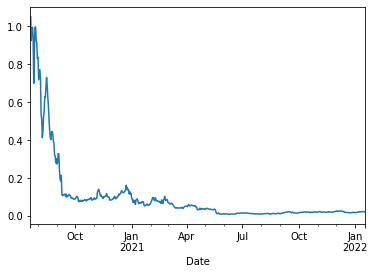

In [139]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

Step 3: Split the data into training and testing datasets.

In [140]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-20,0.934303,0.690508
2020-07-21,0.934465,0.691471
2020-07-22,0.934297,0.692418
2020-07-23,0.953673,0.695080
2020-07-24,0.986047,0.698959


In [141]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    288
-1.0    260
Name: Signal, dtype: int64

In [142]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-07-20 00:00:00


In [154]:
# Select the ending period for the training data with an offset of 3 months 
training_end = X.index.min() + DateOffset(months=6)

# Display the training end date
print(training_end)

2021-01-20 00:00:00


In [155]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-20,0.934303,0.690508
2020-07-21,0.934465,0.691471
2020-07-22,0.934297,0.692418
2020-07-23,0.953673,0.695080
2020-07-24,0.986047,0.698959


In [156]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-07-20,0.934303,0.690508
2020-07-21,0.934465,0.691471
2020-07-22,0.934297,0.692418
2020-07-23,0.953673,0.695080
2020-07-24,0.986047,0.698959


In [157]:
X_train.tail()

,SMA_Fast,SMA_Slow
Date,,
2021-01-16,3.413876,2.001404
2021-01-17,3.372290,2.012222
2021-01-18,3.448380,2.025005
2021-01-19,3.577718,2.038899
2021-01-20,3.675644,2.051052


In [158]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [159]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [160]:
# Evaluate the model using a classification report
svm_training_report = classification_report(y_train, svm_pred)
print(svm_training_report)

              precision    recall  f1-score   support

        -1.0       0.58      0.68      0.62        94
         1.0       0.59      0.48      0.53        91

    accuracy                           0.58       185
   macro avg       0.59      0.58      0.58       185
weighted avg       0.59      0.58      0.58       185



In [161]:
# Use the trained model to predict the trading signals for the testing data.
svm_testing_predictions = svm_model.predict(X_test_scaled)

In [162]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_testing_predictions)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.12      0.01      0.02       165
         1.0       0.53      0.93      0.67       197

    accuracy                           0.51       362
   macro avg       0.33      0.47      0.35       362
weighted avg       0.34      0.51      0.38       362



In [163]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)


# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_testing_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Predicted'] * predictions_df['Actual Returns']


# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2021-01-21,-1.0,-0.196865,0.196865
2021-01-22,-1.0,0.118940,-0.118940
2021-01-23,-1.0,0.047182,-0.047182
2021-01-24,-1.0,0.037185,-0.037185
2021-01-25,-1.0,0.018041,-0.018041


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-01-13,1.0,-0.037528,-0.037528
2022-01-14,1.0,0.001020,0.001020
2022-01-15,1.0,0.011235,0.011235
2022-01-16,1.0,0.000374,0.000374
2022-01-17,1.0,-0.053637,-0.053637


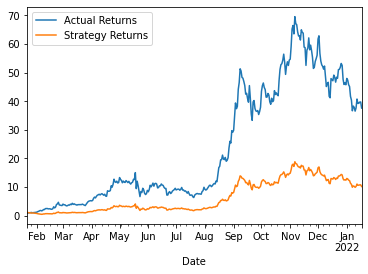

In [164]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()